In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

print("✅ Libraries imported successfully!")

✅ Libraries imported successfully!


In [3]:
from google.colab import files
import io

print("📁 Please upload your Excel files:")
print("   1. Shipping_type.xlsx")
print("   2. customers_f.xlsx")
print("   3. Sales.xlsx")
print("\n👇 Click 'Choose Files' button below and select all 3 files\n")

uploaded = files.upload()

print("\n✅ Files uploaded successfully!")
print(f"📦 Uploaded files: {list(uploaded.keys())}")


📁 Please upload your Excel files:
   1. Shipping_type.xlsx
   2. customers_f.xlsx
   3. Sales.xlsx

👇 Click 'Choose Files' button below and select all 3 files



Saving Customers_f.xlsx to Customers_f (1).xlsx
Saving Sales.xlsx to Sales.xlsx
Saving Shipping_types.xlsx to Shipping_types (1).xlsx

✅ Files uploaded successfully!
📦 Uploaded files: ['Customers_f (1).xlsx', 'Sales.xlsx', 'Shipping_types (1).xlsx']


In [5]:
print("Loading data into dataframes...\n")

# Check what files were uploaded
print("📦 Files you uploaded:")
for filename in uploaded.keys():
    print(f"   - {filename}")

# Load files dynamically (handles any filename variations)
file_list = list(uploaded.keys())

# Find the correct file names
shipping_file = next((f for f in file_list if 'shipping' in f.lower()), None)
customers_file = next((f for f in file_list if 'customer' in f.lower()), None)
sales_file = next((f for f in file_list if 'sale' in f.lower()), None)

if not all([shipping_file, customers_file, sales_file]):
    print("\n❌ Error: Could not find all required files!")
    print("Please make sure you uploaded files with names containing:")
    print("   - 'shipping' or 'Shipping'")
    print("   - 'customer' or 'customers'")
    print("   - 'sale' or 'Sales'")
else:
    # Load the data
    shipping_df = pd.read_excel(io.BytesIO(uploaded[shipping_file]))
    customers_df = pd.read_excel(io.BytesIO(uploaded[customers_file]))
    sales_df = pd.read_excel(io.BytesIO(uploaded[sales_file]))

    print("\n✅ Data loaded successfully!")
    print(f"\n📊 Dataset Shapes:")
    print(f"   Shipping ({shipping_file}): {shipping_df.shape}")
    print(f"   Customers ({customers_file}): {customers_df.shape}")
    print(f"   Sales ({sales_file}): {sales_df.shape}")

Loading data into dataframes...

📦 Files you uploaded:
   - Customers_f (1).xlsx
   - Sales.xlsx
   - Shipping_types (1).xlsx

✅ Data loaded successfully!

📊 Dataset Shapes:
   Shipping (Shipping_types (1).xlsx): (6, 2)
   Customers (Customers_f (1).xlsx): (3900, 10)
   Sales (Sales.xlsx): (499998, 12)


In [6]:
print("="*70)
print("DATA EXPLORATION")
print("="*70)

print("\n📦 SHIPPING DATA")
print(shipping_df.head())
print(f"\nMissing values:\n{shipping_df.isnull().sum()}")

print("\n\n👥 CUSTOMERS DATA")
print(customers_df.head())
print(f"\nMissing values:\n{customers_df.isnull().sum()}")

print("\n\n🛒 SALES DATA")
print(sales_df.head())
print(f"\nMissing values:\n{sales_df.isnull().sum()}")

print(f"\n📋 Sales Data Info:")
print(sales_df.info())

DATA EXPLORATION

📦 SHIPPING DATA
    shipping_type ship_type_code
0         Express       SHIP3159
1   Free Shipping       SHIP9895
2    Next Day Air       SHIP1209
3        Standard       SHIP5341
4  2-Day Shipping       SHIP1507

Missing values:
shipping_type     0
ship_type_code    0
dtype: int64


👥 CUSTOMERS DATA
   code_customer  Age Gender                   Zip_code Preferred_size  \
0              1   55   Male         Lexington_Kentucky              L   
1              2   19   Male               Auburn_Maine              L   
2              3   50   Male  Springfield_Massachusetts              S   
3              4   21   Male      Cranston_Rhode Island              M   
4              5   45   Male              Eugene_Oregon              M   

   Overall_review Subscription Status  Previous Purchases Payment Method  \
0             3.1                 Yes                  14          Venmo   
1             3.1                 Yes                   2           Cash   
2     

In [7]:
print("="*70)
print("FEATURE ENGINEERING")
print("="*70)

# Convert sale_date to datetime
sales_df['sale_date'] = pd.to_datetime(sales_df['sale_date'], errors='coerce')

# Calculate total purchase amount
sales_df['total_amount'] = sales_df['quantity'] * sales_df['Estimated_Unit_Price']

# Aggregate customer spending metrics
customer_spending = sales_df.groupby('code_customer').agg({
    'total_amount': 'sum',
    'code_sale': 'count',
    'sale_date': 'max',
    'is_discounted': 'mean',
    'quantity': 'mean'
}).reset_index()

customer_spending.columns = [
    'code_customer', 'total_spent', 'num_transactions',
    'last_purchase_date', 'discount_rate', 'avg_quantity'
]

# Calculate recency (days since last purchase)
max_date = sales_df['sale_date'].max()
customer_spending['recency_days'] = (max_date - customer_spending['last_purchase_date']).dt.days

# Calculate average order value (TARGET VARIABLE)
customer_spending['avg_order_value'] = customer_spending['total_spent'] / customer_spending['num_transactions']

print(f"✅ Customer spending features created!")
print(f"Shape: {customer_spending.shape}\n")
print(customer_spending.head())


FEATURE ENGINEERING
✅ Customer spending features created!
Shape: (3900, 8)

   code_customer  total_spent  num_transactions last_purchase_date  \
0              1      3104.05               141         2024-12-21   
1              2      2965.99               140         2024-12-25   
2              3      2257.54               107         2024-12-25   
3              4      3367.89               145         2024-12-22   
4              5      3146.16               130         2024-12-23   

   discount_rate  avg_quantity  recency_days  avg_order_value  
0       0.212766      1.382979             6        22.014539  
1       0.242857      1.435714             2        21.185643  
2       0.186916      1.364486             2        21.098505  
3       0.255172      1.455172             5        23.226828  
4       0.207692      1.415385             4        24.201231  


In [8]:
print("="*70)
print("MERGING DATASETS")
print("="*70)

# Merge customer features with spending history
df = customers_df.merge(customer_spending, on='code_customer', how='inner')

print(f"✅ Merged dataset shape: {df.shape}")
print(f"✅ Total columns: {len(df.columns)}")
print(f"\nColumn names:\n{list(df.columns)}")


MERGING DATASETS
✅ Merged dataset shape: (3900, 17)
✅ Total columns: 17

Column names:
['code_customer', 'Age', 'Gender', 'Zip_code', 'Preferred_size', 'Overall_review', 'Subscription Status', 'Previous Purchases', 'Payment Method', 'Frequency of Purchases', 'total_spent', 'num_transactions', 'last_purchase_date', 'discount_rate', 'avg_quantity', 'recency_days', 'avg_order_value']


In [9]:
print("="*70)
print("HANDLING MISSING VALUES")
print("="*70)

print("Missing values BEFORE cleaning:")
print(df.isnull().sum())

# Fill numeric columns with median
numeric_cols = df.select_dtypes(include=[np.number]).columns
for col in numeric_cols:
    if df[col].isnull().sum() > 0:
        df[col].fillna(df[col].median(), inplace=True)

# Fill categorical columns with mode
categorical_cols = df.select_dtypes(include=['object']).columns
for col in categorical_cols:
    if df[col].isnull().sum() > 0:
        df[col].fillna(df[col].mode()[0], inplace=True)

print("\n✅ Missing values AFTER cleaning:")
print(df.isnull().sum())

HANDLING MISSING VALUES
Missing values BEFORE cleaning:
code_customer             0
Age                       0
Gender                    0
Zip_code                  0
Preferred_size            0
Overall_review            0
Subscription Status       0
Previous Purchases        0
Payment Method            0
Frequency of Purchases    0
total_spent               0
num_transactions          0
last_purchase_date        0
discount_rate             0
avg_quantity              0
recency_days              0
avg_order_value           0
dtype: int64

✅ Missing values AFTER cleaning:
code_customer             0
Age                       0
Gender                    0
Zip_code                  0
Preferred_size            0
Overall_review            0
Subscription Status       0
Previous Purchases        0
Payment Method            0
Frequency of Purchases    0
total_spent               0
num_transactions          0
last_purchase_date        0
discount_rate             0
avg_quantity              0
r

In [10]:
print("="*70)
print("ENCODING CATEGORICAL VARIABLES")
print("="*70)

df_encoded = df.copy()

categorical_features = [
    'Preferred_size', 'Gender', 'Subscription Status',
    'Payment Method', 'Frequency of Purchases'
]

label_encoders = {}

for col in categorical_features:
    if col in df_encoded.columns:
        le = LabelEncoder()
        df_encoded[col + '_encoded'] = le.fit_transform(df_encoded[col].astype(str))
        label_encoders[col] = le
        print(f"✅ Encoded '{col}'")
        print(f"   Classes: {list(le.classes_)}\n")

print("✅ All categorical variables encoded!")


ENCODING CATEGORICAL VARIABLES
✅ Encoded 'Preferred_size'
   Classes: ['L', 'M', 'S', 'XL']

✅ Encoded 'Gender'
   Classes: ['Female', 'Male']

✅ Encoded 'Subscription Status'
   Classes: ['No', 'Yes']

✅ Encoded 'Payment Method'
   Classes: ['Bank Transfer', 'Cash', 'Credit Card', 'Debit Card', 'PayPal', 'Venmo']

✅ Encoded 'Frequency of Purchases'
   Classes: ['Annually', 'Bi-Weekly', 'Every 3 Months', 'Fortnightly', 'Monthly', 'Quarterly', 'Weekly']

✅ All categorical variables encoded!


In [11]:
print("="*70)
print("DEFINING FEATURES AND TARGET")
print("="*70)

# Target variable: Average Order Value (future spending proxy)
target = 'avg_order_value'

# Feature columns
feature_columns = [
    'Age',
    'Overall_review',
    'Previous Purchases',
    'recency_days',
    'num_transactions',
    'discount_rate',
    'avg_quantity',
    'total_spent',
    'Preferred_size_encoded',
    'Gender_encoded',
    'Subscription Status_encoded',
    'Payment Method_encoded',
    'Frequency of Purchases_encoded'
]

# Keep only existing columns
feature_columns = [col for col in feature_columns if col in df_encoded.columns]

X = df_encoded[feature_columns]
y = df_encoded[target]

print(f"✅ Features shape: {X.shape}")
print(f"✅ Target shape: {y.shape}")
print(f"\n📋 Features being used:")
for i, col in enumerate(feature_columns, 1):
    print(f"   {i}. {col}")


DEFINING FEATURES AND TARGET
✅ Features shape: (3900, 13)
✅ Target shape: (3900,)

📋 Features being used:
   1. Age
   2. Overall_review
   3. Previous Purchases
   4. recency_days
   5. num_transactions
   6. discount_rate
   7. avg_quantity
   8. total_spent
   9. Preferred_size_encoded
   10. Gender_encoded
   11. Subscription Status_encoded
   12. Payment Method_encoded
   13. Frequency of Purchases_encoded


EXPLORATORY DATA ANALYSIS


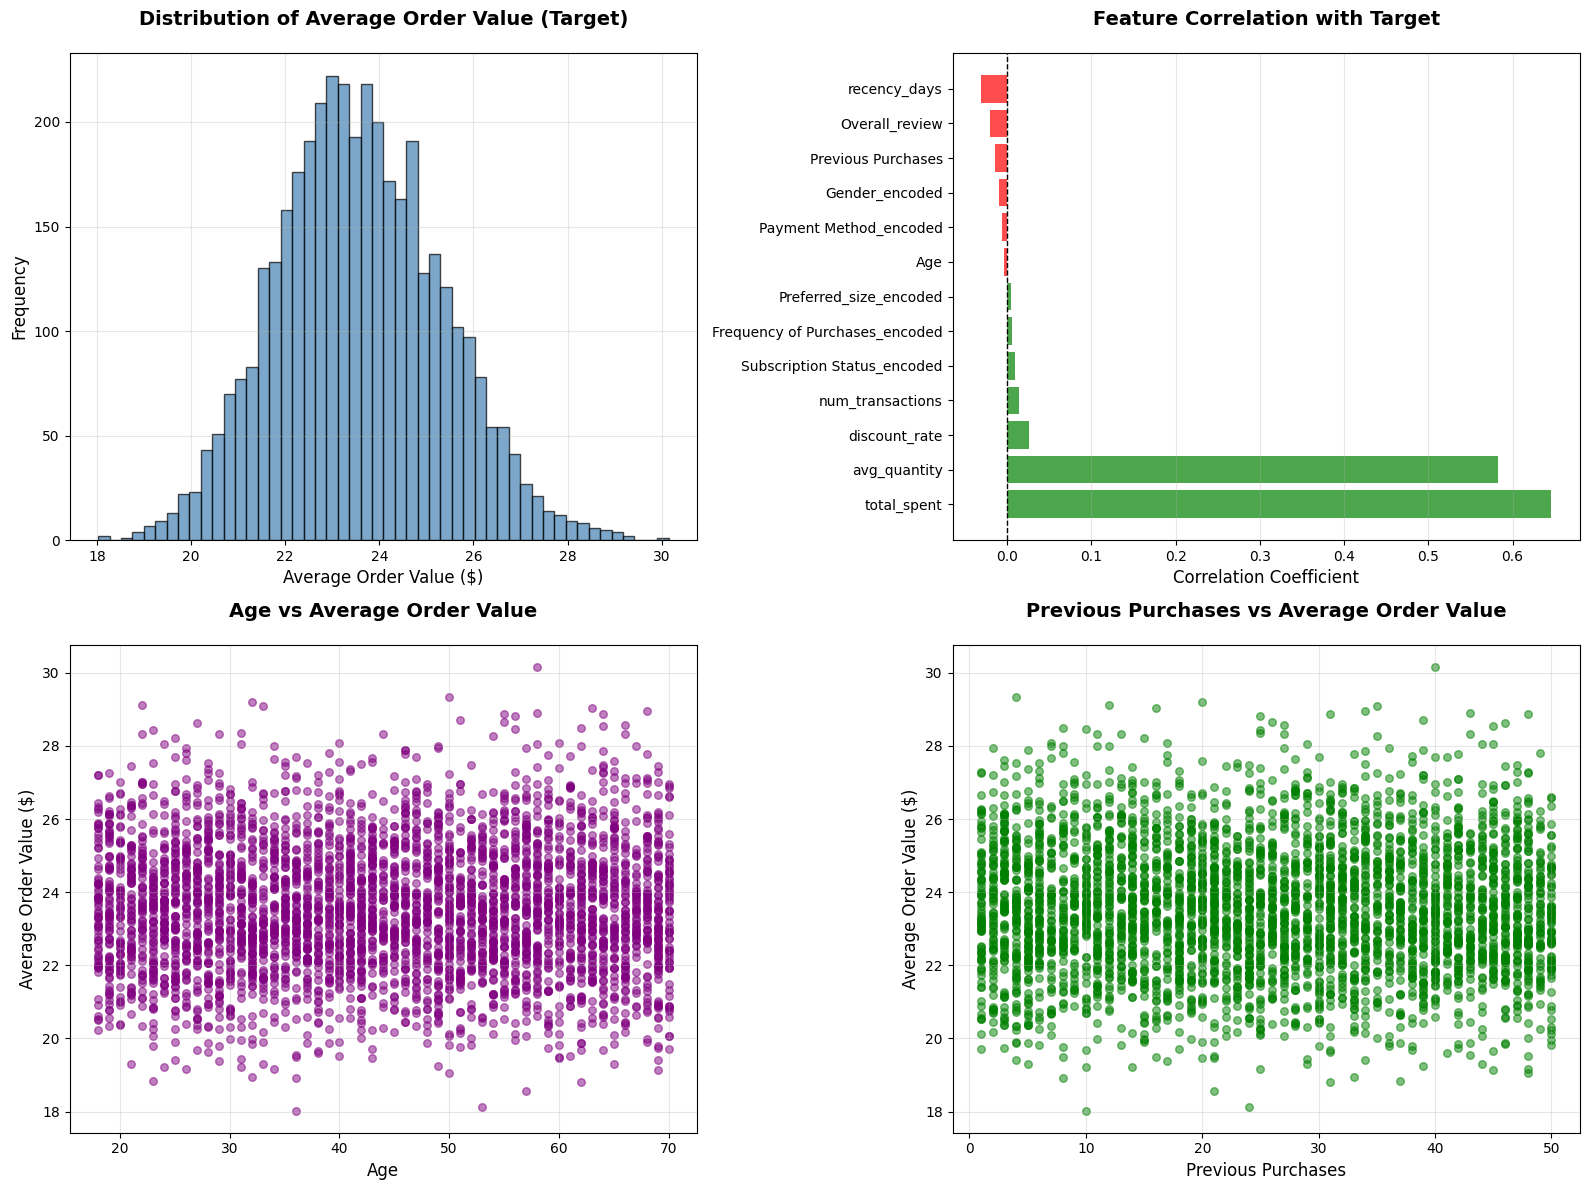


📊 Target Variable Statistics:
   Mean: $23.57
   Median: $23.50
   Std Dev: $1.75
   Min: $18.03
   Max: $30.15


In [12]:
print("="*70)
print("EXPLORATORY DATA ANALYSIS")
print("="*70)

fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# 1. Target Distribution
axes[0, 0].hist(y, bins=50, color='steelblue', edgecolor='black', alpha=0.7)
axes[0, 0].set_title('Distribution of Average Order Value (Target)',
                     fontsize=14, fontweight='bold', pad=20)
axes[0, 0].set_xlabel('Average Order Value ($)', fontsize=12)
axes[0, 0].set_ylabel('Frequency', fontsize=12)
axes[0, 0].grid(alpha=0.3)

# 2. Feature Correlation
corr_data = X.copy()
corr_data['target'] = y
correlation = corr_data.corr()['target'].drop('target').sort_values(ascending=False)
colors = ['green' if x > 0 else 'red' for x in correlation.values]
axes[0, 1].barh(range(len(correlation)), correlation.values, color=colors, alpha=0.7)
axes[0, 1].set_yticks(range(len(correlation)))
axes[0, 1].set_yticklabels(correlation.index, fontsize=10)
axes[0, 1].set_title('Feature Correlation with Target',
                     fontsize=14, fontweight='bold', pad=20)
axes[0, 1].set_xlabel('Correlation Coefficient', fontsize=12)
axes[0, 1].axvline(x=0, color='black', linestyle='--', linewidth=1)
axes[0, 1].grid(alpha=0.3, axis='x')

# 3. Age vs Spending
axes[1, 0].scatter(df_encoded['Age'], y, alpha=0.5, color='purple', s=30)
axes[1, 0].set_title('Age vs Average Order Value',
                     fontsize=14, fontweight='bold', pad=20)
axes[1, 0].set_xlabel('Age', fontsize=12)
axes[1, 0].set_ylabel('Average Order Value ($)', fontsize=12)
axes[1, 0].grid(alpha=0.3)

# 4. Previous Purchases vs Spending
axes[1, 1].scatter(df_encoded['Previous Purchases'], y, alpha=0.5, color='green', s=30)
axes[1, 1].set_title('Previous Purchases vs Average Order Value',
                     fontsize=14, fontweight='bold', pad=20)
axes[1, 1].set_xlabel('Previous Purchases', fontsize=12)
axes[1, 1].set_ylabel('Average Order Value ($)', fontsize=12)
axes[1, 1].grid(alpha=0.3)

plt.tight_layout()
plt.show()

print(f"\n📊 Target Variable Statistics:")
print(f"   Mean: ${y.mean():.2f}")
print(f"   Median: ${y.median():.2f}")
print(f"   Std Dev: ${y.std():.2f}")
print(f"   Min: ${y.min():.2f}")
print(f"   Max: ${y.max():.2f}")

In [13]:
print("="*70)
print("TRAIN-TEST SPLIT")
print("="*70)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

print(f"✅ Training set: {X_train.shape}")
print(f"✅ Test set: {X_test.shape}")
print(f"\n📊 Split ratio: 80% train, 20% test")


TRAIN-TEST SPLIT
✅ Training set: (3120, 13)
✅ Test set: (780, 13)

📊 Split ratio: 80% train, 20% test


In [14]:
print("="*70)
print("FEATURE SCALING")
print("="*70)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("✅ Features scaled using StandardScaler")
print("   (Mean=0, Std=1)")


FEATURE SCALING
✅ Features scaled using StandardScaler
   (Mean=0, Std=1)


MODEL TRAINING

🔹 Training Linear Regression...
   MAE: $0.10
   RMSE: $0.17
   R² Score: 0.9914

🔹 Training Ridge Regression...
   MAE: $0.11
   RMSE: $0.17
   R² Score: 0.9913

🔹 Training Random Forest...
   MAE: $0.12
   RMSE: $0.24
   R² Score: 0.9815

🔹 Training Gradient Boosting...
   MAE: $0.16
   RMSE: $0.25
   R² Score: 0.9814

✅ All models trained successfully!
MODEL COMPARISON

📊 Results Summary:
                      MAE    RMSE      R2
Linear Regression  0.1047  0.1672  0.9914
Ridge Regression   0.1051  0.1677  0.9913
Random Forest      0.1166  0.2445  0.9815
Gradient Boosting  0.1599  0.2451  0.9814


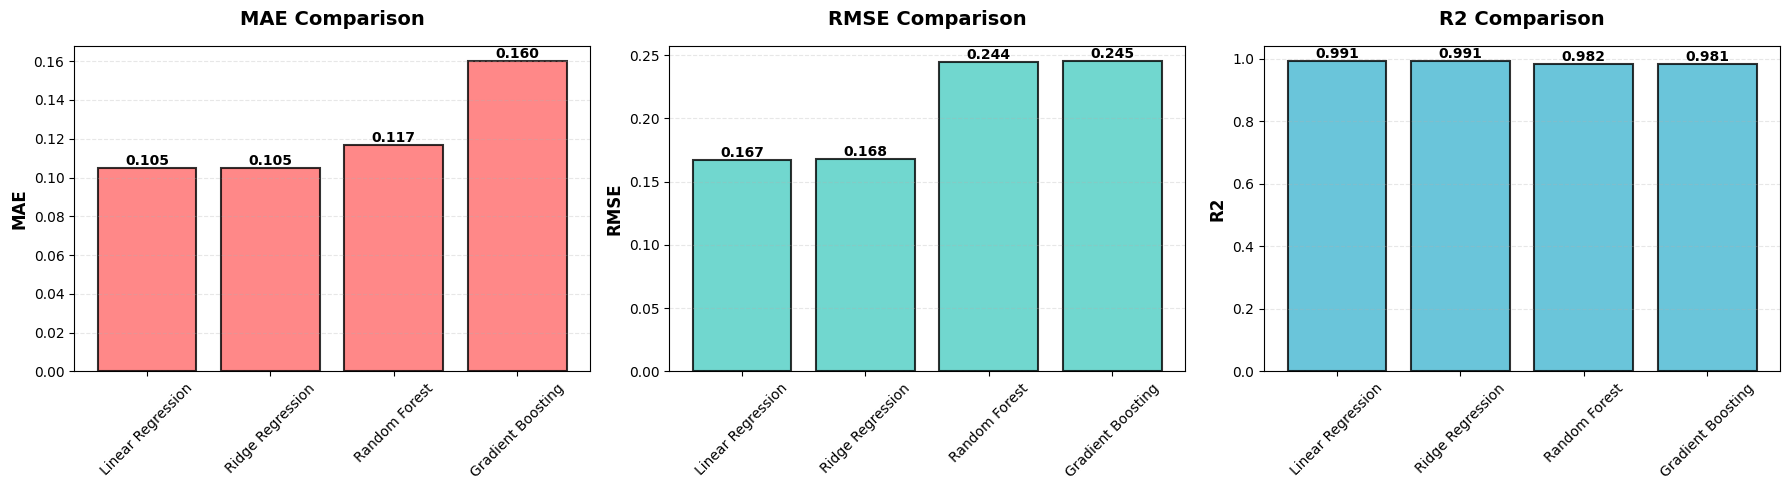


🏆 BEST MODEL: Linear Regression
   R² Score: 0.9914
   RMSE: $0.17
   MAE: $0.10


In [15]:
print("="*70)
print("MODEL TRAINING")
print("="*70)

results = {}

# 1. Linear Regression
print("\n🔹 Training Linear Regression...")
lr = LinearRegression()
lr.fit(X_train_scaled, y_train)
y_pred_lr = lr.predict(X_test_scaled)

results['Linear Regression'] = {
    'MAE': mean_absolute_error(y_test, y_pred_lr),
    'RMSE': np.sqrt(mean_squared_error(y_test, y_pred_lr)),
    'R2': r2_score(y_test, y_pred_lr)
}
print(f"   MAE: ${results['Linear Regression']['MAE']:.2f}")
print(f"   RMSE: ${results['Linear Regression']['RMSE']:.2f}")
print(f"   R² Score: {results['Linear Regression']['R2']:.4f}")

# 2. Ridge Regression
print("\n🔹 Training Ridge Regression...")
ridge = Ridge(alpha=1.0)
ridge.fit(X_train_scaled, y_train)
y_pred_ridge = ridge.predict(X_test_scaled)

results['Ridge Regression'] = {
    'MAE': mean_absolute_error(y_test, y_pred_ridge),
    'RMSE': np.sqrt(mean_squared_error(y_test, y_pred_ridge)),
    'R2': r2_score(y_test, y_pred_ridge)
}
print(f"   MAE: ${results['Ridge Regression']['MAE']:.2f}")
print(f"   RMSE: ${results['Ridge Regression']['RMSE']:.2f}")
print(f"   R² Score: {results['Ridge Regression']['R2']:.4f}")

# 3. Random Forest
print("\n🔹 Training Random Forest...")
rf = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1)
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)

results['Random Forest'] = {
    'MAE': mean_absolute_error(y_test, y_pred_rf),
    'RMSE': np.sqrt(mean_squared_error(y_test, y_pred_rf)),
    'R2': r2_score(y_test, y_pred_rf)
}
print(f"   MAE: ${results['Random Forest']['MAE']:.2f}")
print(f"   RMSE: ${results['Random Forest']['RMSE']:.2f}")
print(f"   R² Score: {results['Random Forest']['R2']:.4f}")

# 4. Gradient Boosting
print("\n🔹 Training Gradient Boosting...")
gb = GradientBoostingRegressor(n_estimators=100, random_state=42)
gb.fit(X_train, y_train)
y_pred_gb = gb.predict(X_test)

results['Gradient Boosting'] = {
    'MAE': mean_absolute_error(y_test, y_pred_gb),
    'RMSE': np.sqrt(mean_squared_error(y_test, y_pred_gb)),
    'R2': r2_score(y_test, y_pred_gb)
}
print(f"   MAE: ${results['Gradient Boosting']['MAE']:.2f}")
print(f"   RMSE: ${results['Gradient Boosting']['RMSE']:.2f}")
print(f"   R² Score: {results['Gradient Boosting']['R2']:.4f}")

print("\n✅ All models trained successfully!")

# ============================================================================
# CELL 14: Compare Models
# ============================================================================
print("="*70)
print("MODEL COMPARISON")
print("="*70)

results_df = pd.DataFrame(results).T
results_df = results_df.round(4)

print("\n📊 Results Summary:")
print(results_df)

# Visualize comparison
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

metrics = ['MAE', 'RMSE', 'R2']
colors_palette = ['#FF6B6B', '#4ECDC4', '#45B7D1']

for idx, metric in enumerate(metrics):
    bars = axes[idx].bar(results_df.index, results_df[metric],
                         color=colors_palette[idx], alpha=0.8, edgecolor='black', linewidth=1.5)
    axes[idx].set_title(f'{metric} Comparison', fontsize=14, fontweight='bold', pad=15)
    axes[idx].set_ylabel(metric, fontsize=12, fontweight='bold')
    axes[idx].tick_params(axis='x', rotation=45, labelsize=10)
    axes[idx].grid(alpha=0.3, axis='y', linestyle='--')

    # Add value labels on bars
    for bar in bars:
        height = bar.get_height()
        axes[idx].text(bar.get_x() + bar.get_width()/2., height,
                      f'{height:.3f}', ha='center', va='bottom',
                      fontsize=10, fontweight='bold')

plt.tight_layout()
plt.show()

# Find best model
best_model = results_df['R2'].idxmax()
print(f"\n🏆 BEST MODEL: {best_model}")
print(f"   R² Score: {results_df.loc[best_model, 'R2']:.4f}")
print(f"   RMSE: ${results_df.loc[best_model, 'RMSE']:.2f}")
print(f"   MAE: ${results_df.loc[best_model, 'MAE']:.2f}")

FEATURE IMPORTANCE ANALYSIS

📊 Feature Importance Rankings:
                           Feature  Importance
7                      total_spent    0.562379
4                 num_transactions    0.308020
6                     avg_quantity    0.117800
5                    discount_rate    0.001974
2               Previous Purchases    0.001717
0                              Age    0.001695
1                   Overall_review    0.001531
3                     recency_days    0.001260
12  Frequency of Purchases_encoded    0.001078
11          Payment Method_encoded    0.001076
8           Preferred_size_encoded    0.000761
10     Subscription Status_encoded    0.000403
9                   Gender_encoded    0.000306


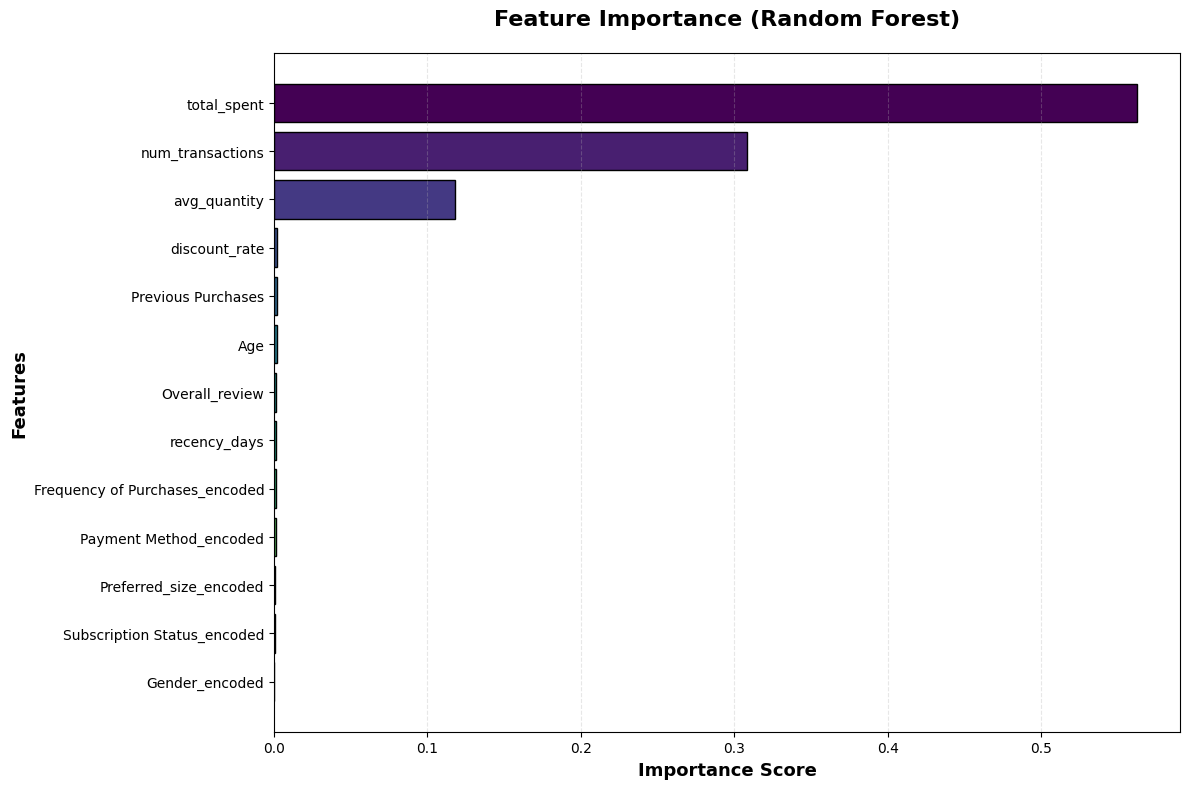


💡 Top 3 Most Important Features:
   1. total_spent: 0.5624
   2. num_transactions: 0.3080
   3. avg_quantity: 0.1178


In [16]:
print("="*70)
print("FEATURE IMPORTANCE ANALYSIS")
print("="*70)

feature_importance = pd.DataFrame({
    'Feature': feature_columns,
    'Importance': rf.feature_importances_
}).sort_values('Importance', ascending=False)

print("\n📊 Feature Importance Rankings:")
print(feature_importance)

# Visualize
plt.figure(figsize=(12, 8))
colors_gradient = plt.cm.viridis(np.linspace(0, 1, len(feature_importance)))
bars = plt.barh(feature_importance['Feature'], feature_importance['Importance'],
                color=colors_gradient, edgecolor='black', linewidth=1)
plt.xlabel('Importance Score', fontsize=13, fontweight='bold')
plt.ylabel('Features', fontsize=13, fontweight='bold')
plt.title('Feature Importance (Random Forest)', fontsize=16, fontweight='bold', pad=20)
plt.gca().invert_yaxis()
plt.grid(alpha=0.3, axis='x', linestyle='--')
plt.tight_layout()
plt.show()

print(f"\n💡 Top 3 Most Important Features:")
for i, (idx, row) in enumerate(feature_importance.head(3).iterrows(), 1):
    print(f"   {i}. {row['Feature']}: {row['Importance']:.4f}")

PREDICTION ANALYSIS


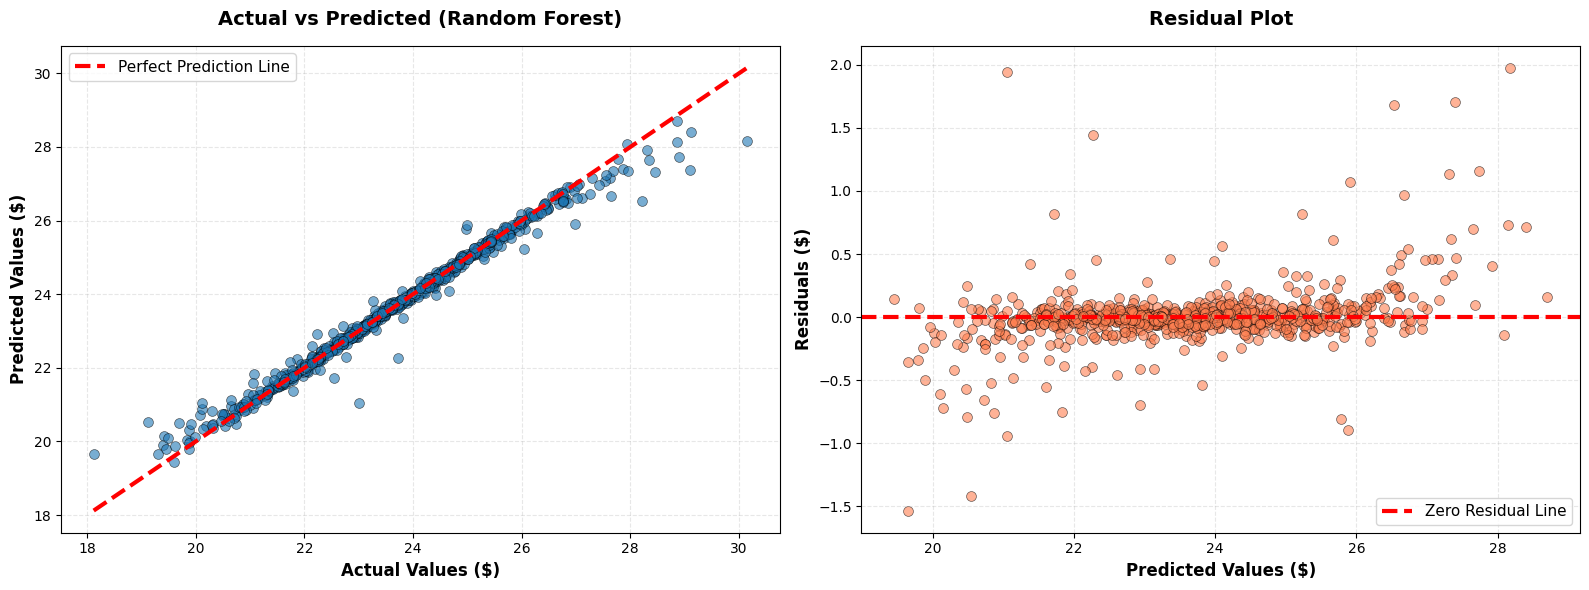

In [17]:
print("="*70)
print("PREDICTION ANALYSIS")
print("="*70)

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Actual vs Predicted
axes[0].scatter(y_test, y_pred_rf, alpha=0.6, s=50, edgecolors='black', linewidth=0.5)
axes[0].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()],
             'r--', lw=3, label='Perfect Prediction Line')
axes[0].set_xlabel('Actual Values ($)', fontsize=12, fontweight='bold')
axes[0].set_ylabel('Predicted Values ($)', fontsize=12, fontweight='bold')
axes[0].set_title('Actual vs Predicted (Random Forest)',
                  fontsize=14, fontweight='bold', pad=15)
axes[0].legend(fontsize=11)
axes[0].grid(alpha=0.3, linestyle='--')

# Residuals Plot
residuals = y_test - y_pred_rf
axes[1].scatter(y_pred_rf, residuals, alpha=0.6, s=50,
                color='coral', edgecolors='black', linewidth=0.5)
axes[1].axhline(y=0, color='red', linestyle='--', lw=3, label='Zero Residual Line')
axes[1].set_xlabel('Predicted Values ($)', fontsize=12, fontweight='bold')
axes[1].set_ylabel('Residuals ($)', fontsize=12, fontweight='bold')
axes[1].set_title('Residual Plot', fontsize=14, fontweight='bold', pad=15)
axes[1].legend(fontsize=11)
axes[1].grid(alpha=0.3, linestyle='--')

plt.tight_layout()
plt.show()

In [18]:
print("="*70)
print("SAMPLE PREDICTIONS")
print("="*70)

sample_predictions = pd.DataFrame({
    'Customer_ID': y_test.iloc[:10].index,
    'Actual_Spending': y_test.iloc[:10].values.round(2),
    'Predicted_Spending': y_pred_rf[:10].round(2),
    'Difference': (y_test.iloc[:10].values - y_pred_rf[:10]).round(2),
    'Error_%': ((y_test.iloc[:10].values - y_pred_rf[:10]) / y_test.iloc[:10].values * 100).round(2)
})

print("\n📋 First 10 Predictions:")
print(sample_predictions.to_string(index=False))


SAMPLE PREDICTIONS

📋 First 10 Predictions:
 Customer_ID  Actual_Spending  Predicted_Spending  Difference  Error_%
         839            20.80               20.85       -0.05    -0.24
        1717            23.45               23.50       -0.05    -0.22
         321            24.13               24.02        0.11     0.47
        3187            24.04               24.01        0.04     0.15
        2269            22.28               22.27        0.01     0.06
         366            26.08               26.05        0.03     0.13
        2644            19.40               19.89       -0.50    -2.56
        1749            24.32               24.26        0.06     0.24
        3605            25.49               25.50       -0.01    -0.02
        1096            20.87               20.94       -0.07    -0.34


In [19]:
print("\n" + "="*70)
print("FINAL SUMMARY")
print("="*70)

print(f"\n📊 DATASET OVERVIEW:")
print(f"   Total Customers Analyzed: {df.shape[0]:,}")
print(f"   Number of Features Used: {len(feature_columns)}")
print(f"   Training Samples: {X_train.shape[0]:,}")
print(f"   Test Samples: {X_test.shape[0]:,}")

print(f"\n🎯 BEST MODEL PERFORMANCE: {best_model}")
print(f"   R² Score: {results_df.loc[best_model, 'R2']:.4f}")
print(f"   RMSE: ${results_df.loc[best_model, 'RMSE']:.2f}")
print(f"   MAE: ${results_df.loc[best_model, 'MAE']:.2f}")

print(f"\n💡 KEY INSIGHTS:")
print(f"   • The model explains {results_df.loc[best_model, 'R2']*100:.2f}% of variance in customer spending")
print(f"   • Average prediction error: ${results_df.loc[best_model, 'MAE']:.2f}")
print(f"   • Top predictive factor: {feature_importance.iloc[0]['Feature']}")

print("\n" + "="*70)
print("✅ ANALYSIS COMPLETE!")
print("="*70)
print("\n🚀 Model is ready for deployment!")
print("📥 Download this notebook: File → Download → Download .ipynb")


FINAL SUMMARY

📊 DATASET OVERVIEW:
   Total Customers Analyzed: 3,900
   Number of Features Used: 13
   Training Samples: 3,120
   Test Samples: 780

🎯 BEST MODEL PERFORMANCE: Linear Regression
   R² Score: 0.9914
   RMSE: $0.17
   MAE: $0.10

💡 KEY INSIGHTS:
   • The model explains 99.14% of variance in customer spending
   • Average prediction error: $0.10
   • Top predictive factor: total_spent

✅ ANALYSIS COMPLETE!

🚀 Model is ready for deployment!
📥 Download this notebook: File → Download → Download .ipynb
